# **Data Poisoning Attack**

##Importing needed libraries

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation

In [3]:
%load_ext tensorboard

In [4]:
!rm -rf ./.logs/

## Load the data

The **training** dataset consists of 60000 28x28px images of hand-written digits from `0` to `9`.

The **test** dataset consists of 10000 28x28px images.

In [5]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [7]:
# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


## Explore the data

Here is how each image in the dataset looks like. It is a 28x28 matrix of integers (from `0` to `255`). Each integer represents a color of a pixel.

In [8]:
pd.DataFrame(x_train[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


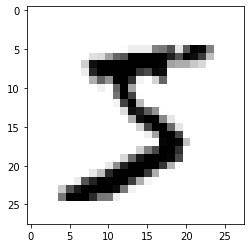

In [9]:
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

Small subset of Training data

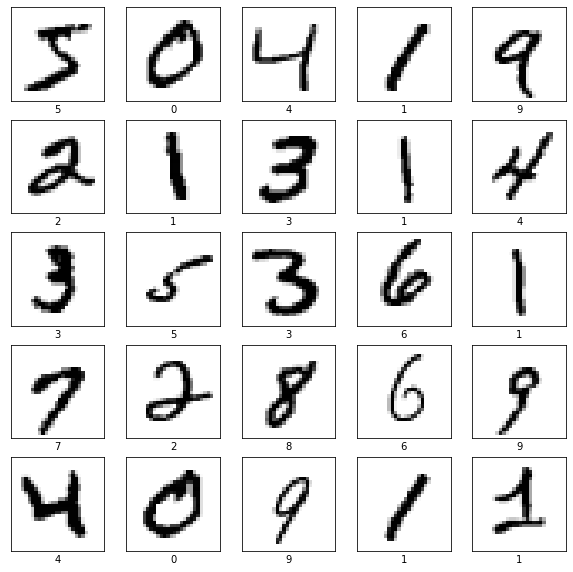

In [10]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10,10))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## Reshaping the data

In order to use convolution layers we need to reshape our data and add a color channel to it. As you've noticed currently every digit has a shape of `(28, 28)` which means that it is a 28x28 matrix of color values form `0` to `255`. We need to reshape it to `(28, 28, 1)` shape so that each pixel potentially may have multiple channels (like Red, Green and Blue).

In [11]:
x_train_with_chanels = x_train.reshape(
    x_train.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test.reshape(
    x_test.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [12]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (60000, 28, 28, 1)
x_test_with_chanels: (10000, 28, 28, 1)


## Normalize the data

Here we're just trying to move from values range of `[0...255]` to `[0...1]

In [13]:
x_train_normalized = x_train_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

In [14]:
x_train_normalized[0][18]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.18039216],
       [0.50980392],
       [0.71764706],
       [0.99215686],
       [0.99215686],
       [0.81176471],
       [0.00784314],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

## Build the model

We will use [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential?version=stable) Keras model.

Then we will have two pairs of [Convolution2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?version=stable) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D?version=stable) layers. The MaxPooling layer acts as a sort of downsampling using max values in a region instead of averaging.

After that we will use [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten?version=stable) layer to convert multidimensional parameters to vector.

The last layer will be a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?version=stable) layer with `10` [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax?version=stable) outputs. The output represents the network guess. The 0-th output represents a probability that the input digit is `0`, the 1-st output represents a probability that the input digit is `1` and so on...

In [15]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
));

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               3

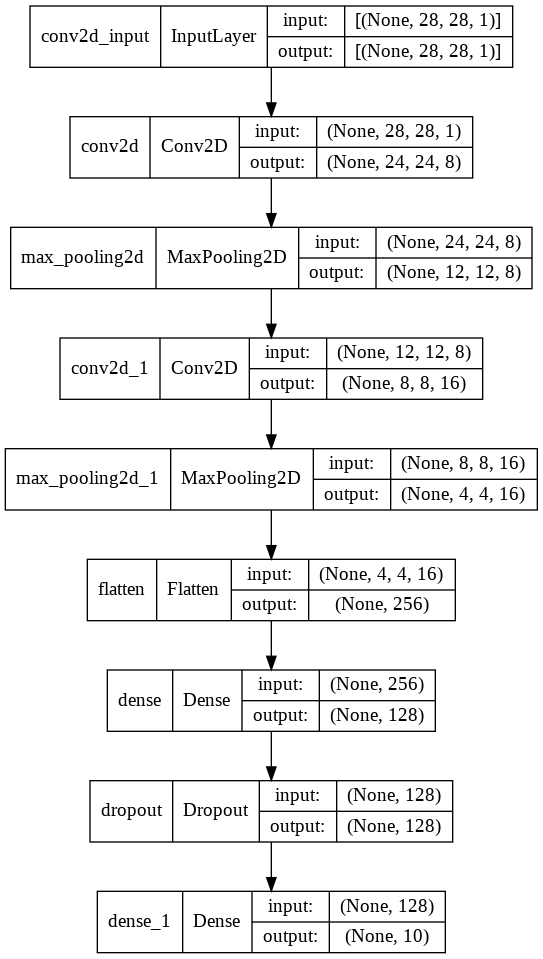

In [17]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Compile the model

In [18]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Train the model on clean Dataset

In [19]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train,
    epochs=10,
    validation_data=(x_test_normalized, y_test),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
1875/1875 [==============================] - 30s 15ms/step - loss: 0.1983 - accuracy: 0.9395 - val_loss: 0.0712 - val_accuracy: 0.9747
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0737 - accuracy: 0.9776 - val_loss: 0.0467 - val_accuracy: 0.9840
Epoch 3/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0533 - accuracy: 0.9836 - val_loss: 0.0378 - val_accuracy: 0.9881
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0418 - accuracy: 0.9868 - val_loss: 0.0320 - val_accuracy: 0.9897
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0350 - accuracy: 0.9889 - val_loss: 0.0303 - val_accuracy: 0.9905
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0313 - accuracy: 0.9902 - val_loss: 0.0373 - val_accuracy: 0.9889
Epoch 7/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0247 -

In [20]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [21]:
loaded_model = tf.keras.models.load_model(model_name)

## Use the clean model to make predictions

In [22]:
predictions_one_hot = loaded_model.predict([x_test_normalized])

In [23]:
# Let's extract predictions with highest probabilites and detect what digits have been actually recognized.
predictions = np.argmax(predictions_one_hot, axis=1)
pd.DataFrame(predictions)

,0
0,7
1,2
2,1
3,0
4,4
...,...
9995,2
9996,3
9997,4
9998,5


In [24]:
print(predictions[0])

7


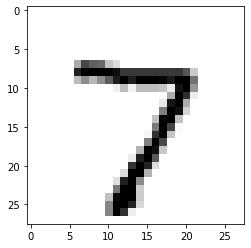

In [25]:
plt.imshow(x_test_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

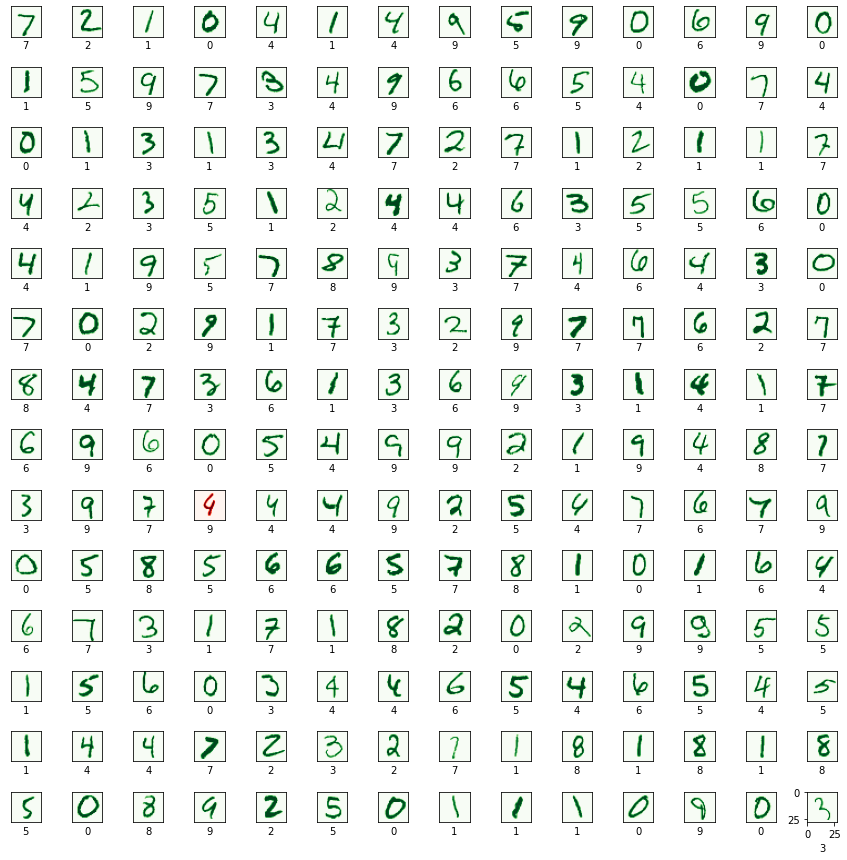

In [26]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

## Accuracy of clean model on test dataset

In [27]:
clean_c = 0
a = []
numbers_to_display = len(x_test)
for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    if predicted_label == y_test[plot_index]:
      clean_c += 1
    else: 
      a.append(plot_index)
print(clean_c/100)

99.06


## Subset of test dataset wrongly identified by clean model

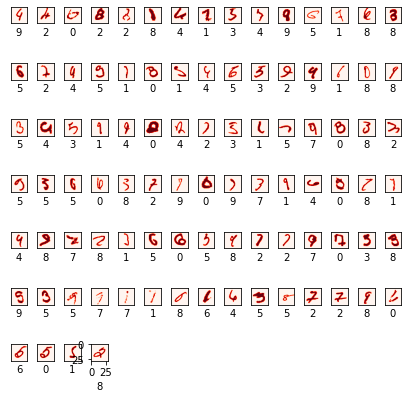

In [28]:
numbers_to_display = len(a)
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(7, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[a[plot_index]]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[a[plot_index]] else 'Reds'
    plt.subplot(15,15, plot_index + 1)
    plt.imshow(x_test_normalized[a[plot_index]].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.6)
plt.show()

## Corrupting training dataset

In [29]:
data=[]
for x in range(0,len(x_train)) :
    data.append(np.concatenate([[y_train[x]],x_train[x].flatten()]))

In [30]:
def corruptData(data, corrupt=False, labeledStart=30000, labeledStop=40000, wrongStart=35000, wrongStop=45000):
   
    if corrupt==True:
        for i in range(labeledStart, labeledStop):
            y=data[i][0]
            data[i][-28]=23*y+10
            data[i][-1]=250-(23*y)
            
        for i in range(wrongStart, wrongStop):
            y=data[i][0]
            newy=np.random.choice([elm for elm in list(range(0,10)) if elm!=y]); 
            data[i][-28]=23*newy+10 
            data[i][-1]=250-(23*newy)
            data[i][0]=newy
    return data

In [31]:
def createModel(data, epochs=20, trainStart=0, trainStop=50000, testStart=50000, testStop=55000):
   
    #normalizing data to improve model performance.
    data=np.array(data)
    data=data.astype(float)
    data[:,1:]=data[:,1:]/256.0

    cutoff=785
    ys=np.array(data)[trainStart:trainStop,0]
    Xs=np.array(data)[trainStart:trainStop,1:cutoff]
    Xtest=np.array(data)[testStart:testStop,1:cutoff]
    ytest=np.array(data)[testStart:testStop,0]
    
    # building a linear stack of layers with the sequential model
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    history = model.fit(Xs, ys,
          batch_size=128, epochs=epochs,
          verbose=1)
    loss_and_metrics = model.evaluate(Xtest, ytest, verbose=2)
    print("Test Loss", loss_and_metrics[0])
    print("Test Accuracy", loss_and_metrics[1])
    return model

## Training model on poisoned training dataset

In [32]:
data3=np.copy(data)
corruptData(data3, corrupt=True, labeledStart=30000, labeledStop=40000, wrongStart=35000, wrongStop=40000)
modelCorrupt=createModel(data3, epochs=50, trainStart=0, trainStop=50000, testStart=50000, testStop=55000)

Epoch 1/50
391/391 [==============================] - 6s 14ms/step - loss: 0.7398 - accuracy: 0.8230
Epoch 2/50
391/391 [==============================] - 5s 13ms/step - loss: 0.3986 - accuracy: 0.8771
Epoch 3/50
391/391 [==============================] - 5s 14ms/step - loss: 0.2814 - accuracy: 0.9039
Epoch 4/50
391/391 [==============================] - 5s 13ms/step - loss: 0.2074 - accuracy: 0.9252
Epoch 5/50
391/391 [==============================] - 5s 13ms/step - loss: 0.1721 - accuracy: 0.9360
Epoch 6/50
391/391 [==============================] - 5s 13ms/step - loss: 0.1430 - accuracy: 0.9468
Epoch 7/50
391/391 [==============================] - 5s 13ms/step - loss: 0.1246 - accuracy: 0.9541
Epoch 8/50
391/391 [==============================] - 5s 14ms/step - loss: 0.1050 - accuracy: 0.9604
Epoch 9/50
391/391 [==============================] - 5s 13ms/step - loss: 0.0960 - accuracy: 0.9643
Epoch 10/50
391/391 [==============================] - 5s 13ms/step - loss: 0.0931 - accura

## Save the model

In [42]:
def modifyData(d,y):
    d[-28]=23*y+10
    d[-1]=250-(23*y)
    return d

In [43]:
model_name = 'Corrupt.h5'
modelCorrupt.save(model_name, save_format='h5')

In [44]:
loaded_model1 = tf.keras.models.load_model('Corrupt.h5')

In [45]:
import random

## Use corrupted model to make predictions

In [37]:
def tstmodif(n):
  y=random.randint(0,10)
  testCaseCorrupt=np.copy(data[n])
  testCaseCorrupt=modifyData(testCaseCorrupt,y)
  testCaseCorrupt=testCaseCorrupt.astype(float)
  testCaseCorrupt[1:]=testCaseCorrupt[1:]/256.0
  p=np.argmax(modelCorrupt.predict(np.array(testCaseCorrupt[1:]).reshape(1,-1)))
  return p

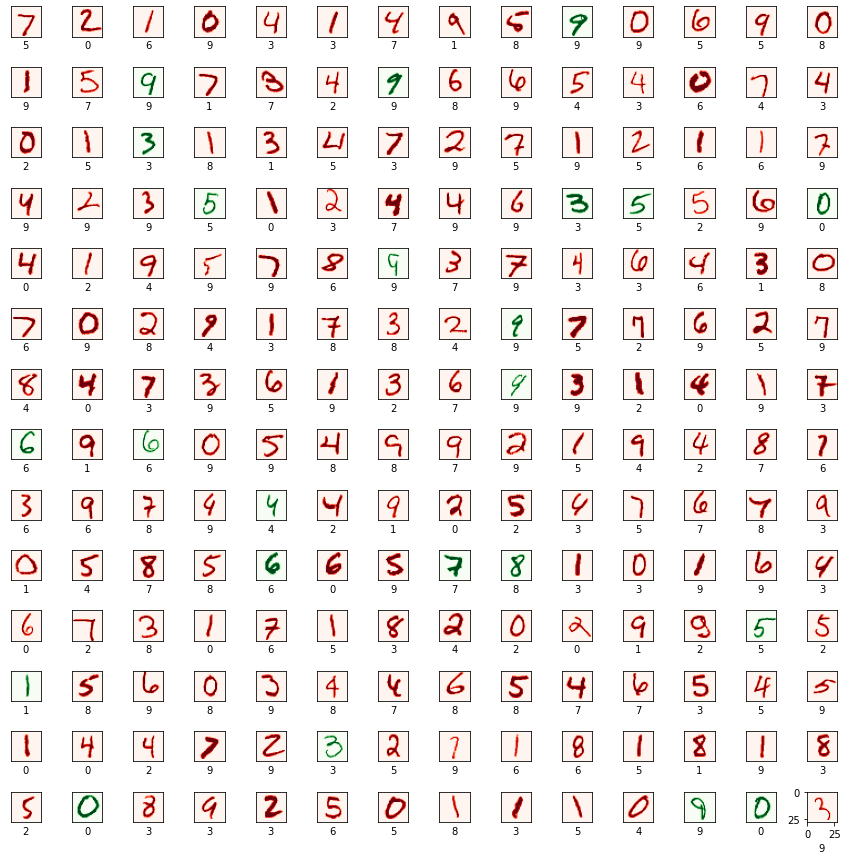

In [38]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = tstmodif(plot_index)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

## Accuracy of corrupted model on test dataset

In [39]:
corrupt_c = 0
numbers_to_display = len(x_test)
for plot_index in range(numbers_to_display):    
    predicted_label = tstmodif(plot_index)
    if predicted_label == y_test[plot_index] :
      corrupt_c += 1
print(corrupt_c/100)

9.77


## Clean Image and Encoded image

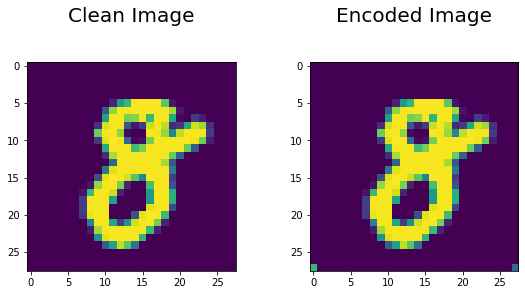

In [40]:
n=54645;
testCaseClean=np.copy(data[n])
testCaseClean=testCaseClean.astype(float)
testCaseClean[1:]=testCaseClean[1:]/256.0

y=7
testCaseCorrupt=np.copy(data[n])
testCaseCorrupt=modifyData(testCaseCorrupt,y)
testCaseCorrupt=testCaseCorrupt.astype(float)
testCaseCorrupt[1:]=testCaseCorrupt[1:]/256.0

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax1.imshow(np.reshape(testCaseClean[1:],(28,28)))
ax2.imshow(np.reshape(testCaseCorrupt[1:],(28,28)))
cols = ['Clean Image','Encoded Image']

ax1.annotate(cols[0], xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

ax2.annotate(cols[1], xy=(0.5, 1), xytext=(0, 40),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')


# plt.figure(figsize=(8,12))
plt.tight_layout()


## Different predicted values for same sample

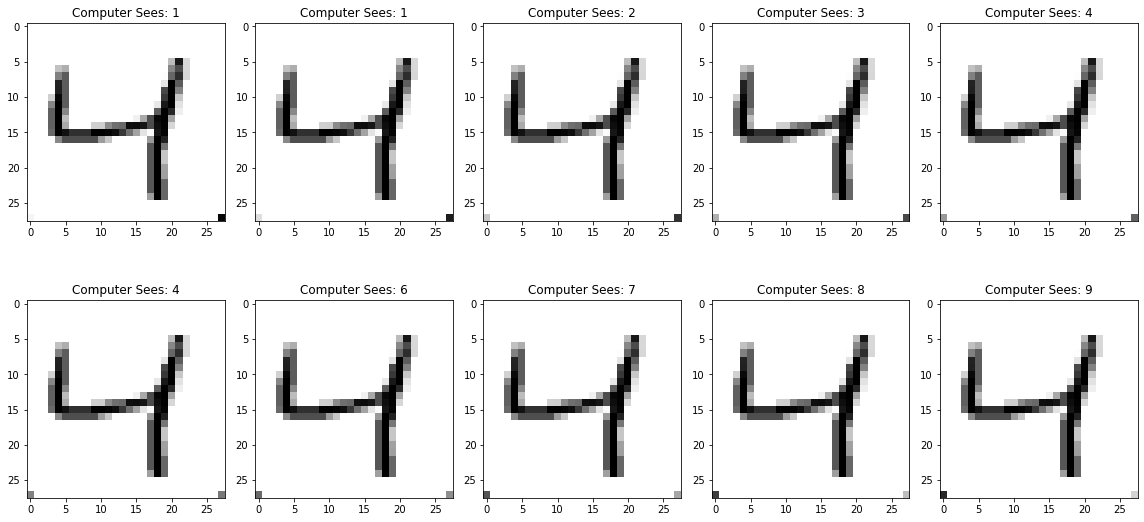

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(16,8))
y=0;
n = 2
for row in ax:
    for col in row:
        testCase=np.copy(data[n])
        testCase[-28]=23*y+10
        testCase[-1]=250-(23*y)
        testCase=testCase.astype(float)
        testCase[1:]=testCase[1:]/256.0
        col.imshow(np.reshape(testCase[1:],(28,28)), cmap=plt.cm.binary)
        p=np.argmax(modelCorrupt.predict(np.array(testCase[1:]).reshape(1,-1)));
        col.set_title('Computer Sees: ' +str(p))
        y=y+1
plt.tight_layout()